In [25]:
%run ../scripts/notebook_settings_lean.py
from scipy import stats
from horizonplot import horizonplot
from chromwindow import window

In [26]:
def create_paint_df_ind_compressed(df, ind, mapping, ns_map):
    d = {}
    max_pos = int(df.epos.iloc[-1])
    df = df.loc[df[ind].shift() != df[ind]].reset_index()
    df["epos"] = pd.concat([df.spos.iloc[1:], pd.Series(max_pos)], ignore_index=True)
    d["pos"] = df.spos
    d["end_pos"] = df.epos -1
    d["length"] = df.epos - df.spos
    d["reference"] = df[ind].map(mapping)
    d["n/s"] = d["reference"].map(ns_map)
    d["individual"] = ind[:-2]
    d["haplotype"] = ind[-1:]
    return pd.DataFrame(d)

In [27]:
meta_data_samples = pd.read_csv("../data/Papio_metadata_with_clustering_sci.txt", sep =" ")
rfmix_path = "/home/eriks/baboondiversity/people/eriks/second_analysis_baboons/steps/rfmix_gen100/tanzania_focus/"
mapping_df = pd.read_csv(rfmix_path + "ref_names.txt", sep = "\t", names=["ID", "Origin"])

pop_mapping = {}
o_order = sorted((mapping_df.Origin.unique()))
for o in range(len((mapping_df.Origin.unique()))):
    pop_mapping[o_order[o]] = o

north_south_mapping = {'Hamadryas, Ethiopia': 1,
 'Kindae, Zambia': 0,
 'Papio, Senegal': 1,
 'Ursinus, Zambia': 0}

In [28]:
df_l = []
for chrom in ["chr{}".format(x) for x in (range(1, 21))]+["all_chrX", "female_chrX"]:
    print(chrom)
    input_file = rfmix_path + "{}.msp.tsv".format(chrom)
    chr_df = pd.read_csv(input_file, sep = "\t", header=1)
    file = open(input_file, 'r')
    line1 = file.readline()
    file.close()
    number_subpop_mapping = {}
    for subpop in line1.strip().split("\t"):
        # Splitting to create lists containing two values - subpop and number.
        subpop_number = subpop.split(": ")[-1].split("=")
        number_subpop_mapping[int(subpop_number[1])] = subpop_number[0]
    for hap in chr_df.columns[6:]:
        paint_df = create_paint_df_ind_compressed(chr_df, hap, number_subpop_mapping, north_south_mapping)
        paint_df["chrom"] = "{}".format(chrom)
        df_l.append(paint_df)
length_df = pd.concat(df_l)

chr1
chr2
chr3
chr4
chr5
chr6
chr7
chr8
chr9
chr10
chr11
chr12
chr13
chr14
chr15
chr16
chr17
chr18
chr19
chr20
all_chrX
female_chrX


In [29]:
df_l = []
for c in length_df.chrom.unique():
    read_file = rfmix_path + "{}.windows.txt".format(c)
    df = pd.read_csv(read_file, sep="\t")
    df_l.append(df)
window_df = pd.concat(df_l)

In [30]:
import geneinfo as gi
%env ftp_proxy http://proxy-default:3128
%env http_proxy http://proxy-default:3128
%env https_proxy http://proxy-default:3128

env: ftp_proxy=http://proxy-default:3128
env: http_proxy=http://proxy-default:3128
env: https_proxy=http://proxy-default:3128


Workflow for getting genic and nongenic regions - first run only on chrX, later on all chromosomes.

In [31]:
pos_mapping = {}
recomb_window_l = []
for c in ["all_chrX"]: #window_df.chrom.unique()[:1]:
    print(c)
    chr_df = window_df.loc[(window_df.chrom == c)]
    windows = chr_df.start.unique()
    max_window = windows.max()
    genetic_map = "/home/eriks/baboondiversity/data/PG_panu3_recombination_map/mikumi_pyrho_genetic_map_{}.txt"
    if c not in ["all_chrX", "female_chrX"]:
        chr_recomb = pd.read_csv(genetic_map.format(c), sep=" ")
        chr_genes = gi.get_genes_region(c, 0, max_window, assembly='papAnu4')
    else:
        chr_recomb = pd.read_csv(genetic_map.format("chrX"), sep=" ")
        chr_genes = gi.get_genes_region('chrX', 0, max_window, assembly='papAnu4')
    for s in chr_df.start.unique():
        if s % 25000000 == 0:
            print(s/max_window)
        cM_pos = chr_recomb.loc[chr_recomb.position >= s]["Genetic_Map(cM)"].iloc[0]
        pos_mapping[s] = cM_pos
    chr_df["cM"] = chr_df.start.map(pos_mapping)
    end_cM = pd.concat([chr_df.cM.iloc[1:], pd.Series(chr_recomb["Genetic_Map(cM)"].max())], ignore_index=True)
    chr_df["average_cM_window"] = (end_cM - chr_df.cM) / (chr_df.end - chr_df.start)
    gene_list = []
    gene_pos_mapping = {}
    for g in chr_genes:
        #print(g)
        if g in gene_list: #or g[0][:3] == "LOC":
            pass
        else:
            gene_list.append(g)
    for w in range(0, max_window+100000, 100000):
        gene_pos_mapping[w] = []
    for g in gene_list:
        s, e = (g[1]//100000)*100000, (g[2]//100000)*100000
        for i in range(s, e+100000, 100000):
            gene_pos_mapping[i].append(g[0])
    chr_df["genes"] = chr_df.start.map(gene_pos_mapping)
    chr_df["genic"] = [True if len(x) > 0 else False for x in chr_df.genes]

all_chrX
0.0
0.17409470752089137
0.34818941504178275
0.5222841225626741
0.6963788300835655
0.8704735376044568


/scratch/23698326/ipykernel_3016234/1182797973.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["cM"] = chr_df.start.map(pos_mapping)
/scratch/23698326/ipykernel_3016234/1182797973.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["average_cM_window"] = (end_cM - chr_df.cM) / (chr_df.end - chr_df.start)
/scratch/23698326/ipykernel_3016234/1182797973.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

In [42]:
chr_df["north_percentage"] = (chr_df.north_sum) / (chr_df.end - chr_df.start)
mean_df = chr_df.groupby(by=["individual", "chrom", "start", "genic"])[["north_percentage", "average_cM_window"]].mean().reset_index()
mean_df["north"] = (mean_df.north_percentage)
chrX_mean_df = mean_df

/scratch/23698326/ipykernel_3016234/1039732412.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["north_percentage"] = (chr_df.north_sum) / (chr_df.end - chr_df.start)


In [33]:
bins = 5
mean_df["recomb_group"] = pd.qcut(mean_df["average_cM_window"], bins, labels=False)

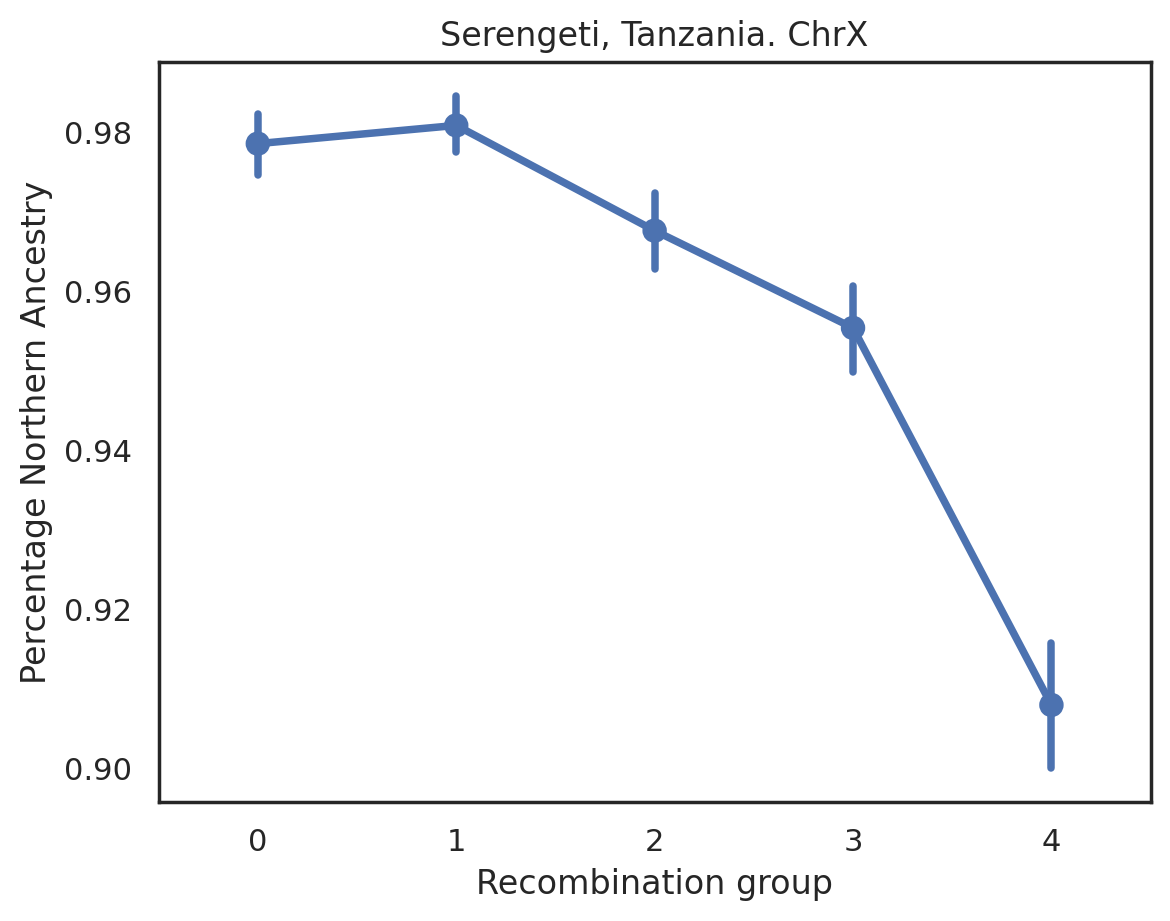

In [34]:
serengeti = meta_data_samples.loc[meta_data_samples.Origin == "Serengeti, Tanzania"].PGDP_ID
df = mean_df.loc[mean_df["individual"].isin(serengeti)]
g = sns.pointplot(data=df, y="north", x="recomb_group", errorbar=('ci', 95))
g.set(title="Serengeti, Tanzania. ChrX")
g.set(xlabel="Recombination group", ylabel="Percentage Northern Ancestry")
plt.savefig("../figures/serengeti_chrX_recomb.png", dpi=300, bbox_inches='tight')

In [35]:
df.loc[df.start.isin((df.groupby(["start"])[["north"]].mean() > 0.05).index)]

,individual,chrom,start,genic,north_percentage,average_cM_window,north,recomb_group
0,PD_0199,all_chrX,0,True,0.00000,9.829296e-06,0.00000,4
1,PD_0199,all_chrX,100000,True,0.00000,3.393394e-06,0.00000,4
2,PD_0199,all_chrX,200000,True,0.00000,1.823823e-06,0.00000,4
3,PD_0199,all_chrX,300000,True,0.00000,1.988331e-06,0.00000,4
4,PD_0199,all_chrX,400000,True,0.00000,4.477935e-07,0.00000,1
...,...,...,...,...,...,...,...,...
91963,PD_0501,all_chrX,143200000,True,1.00000,2.562611e-07,1.00000,0
91964,PD_0501,all_chrX,143300000,True,1.00000,3.373798e-07,1.00000,1
91965,PD_0501,all_chrX,143400000,True,1.00000,2.798504e-07,1.00000,0
91966,PD_0501,all_chrX,143500000,True,1.00000,7.534706e-07,1.00000,2


[Text(0.5, 0, 'Recombination group'),
 Text(0, 0.5, 'Percentage Northern Ancestry')]

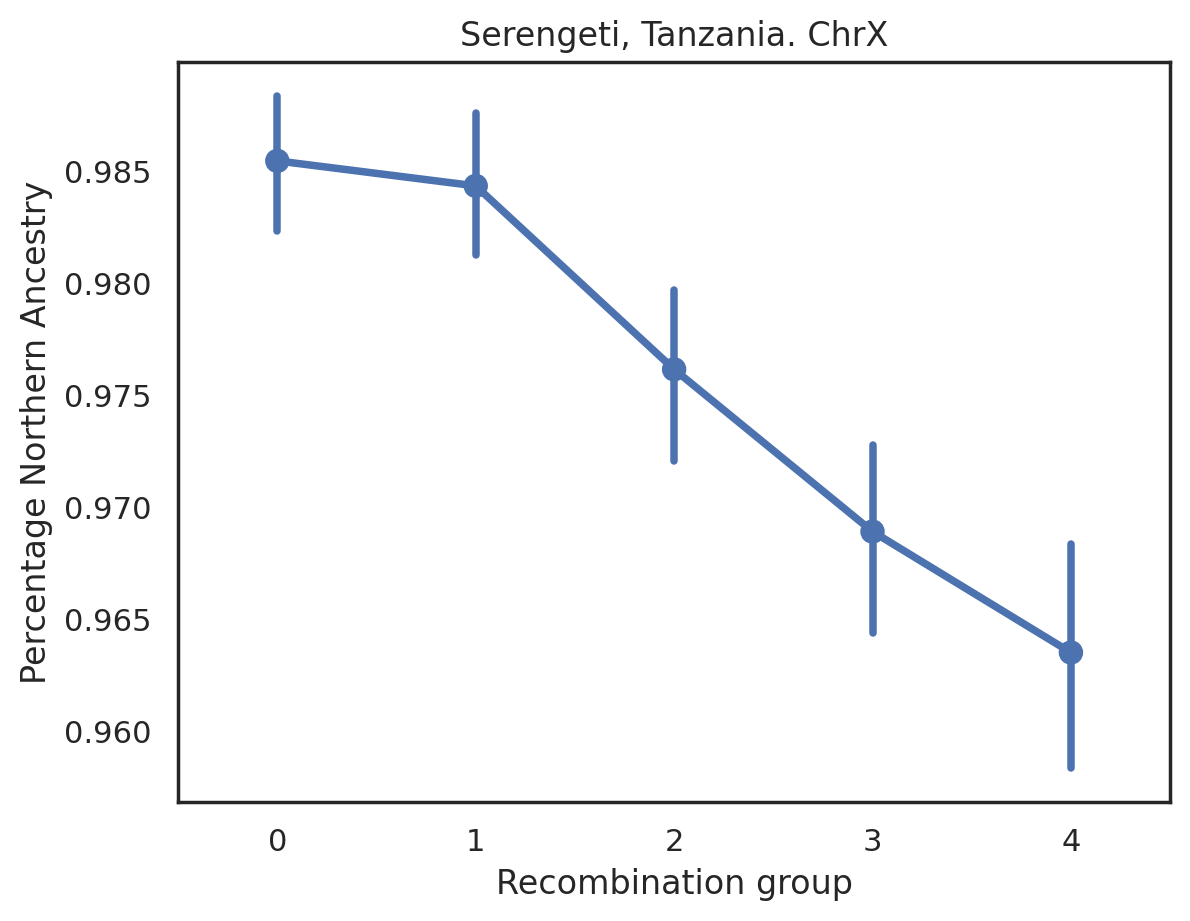

In [36]:
serengeti = meta_data_samples.loc[meta_data_samples.Origin == "Serengeti, Tanzania"].PGDP_ID
df = mean_df.loc[mean_df["individual"].isin(serengeti)]
mean_df_2 = (df.groupby(["start"])[["north"]].mean())
df_2 = df.loc[df.start.isin(mean_df_2.loc[mean_df_2.north > 0.5].index)]
g = sns.pointplot(data=df_2, y="north", x="recomb_group", errorbar=('ci', 95))
g.set(title="Serengeti, Tanzania. ChrX")
g.set(xlabel="Recombination group", ylabel="Percentage Northern Ancestry")

[Text(0.5, 0, 'Recombination group'),
 Text(0, 0.5, 'Percentage Northern Ancestry')]

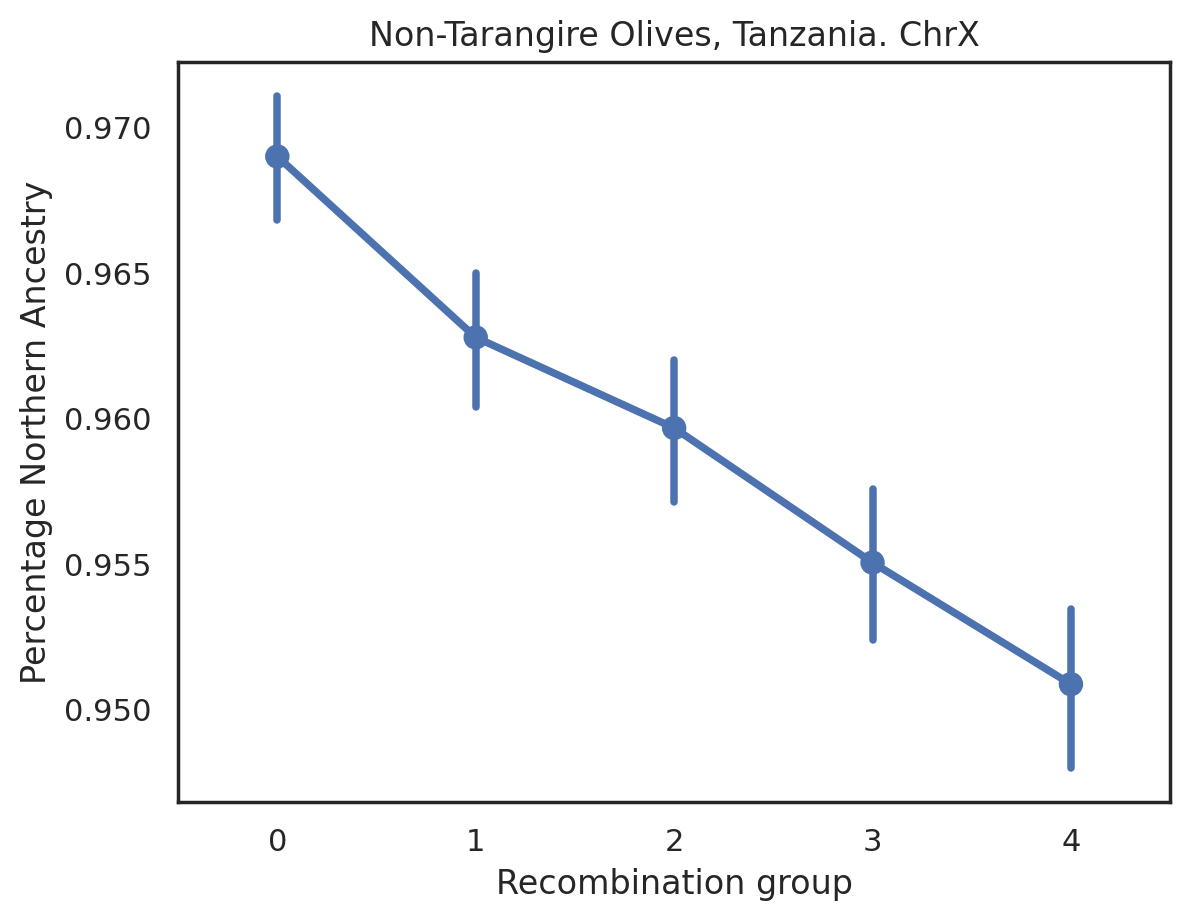

In [37]:
non_taran = meta_data_samples.loc[meta_data_samples.Origin.isin(["Serengeti, Tanzania",
                                                                 "Lake Manyara, Tanzania",
                                                                "Arusha, Tanzania",
                                                                "Gombe, Tanzania",
                                                                "Ngorongoro, Tanzania"])].PGDP_ID
df = mean_df.loc[mean_df["individual"].isin(non_taran)]
mean_df_2 = (df.groupby(["start"])[["north"]].mean())
df_2 = df.loc[df.start.isin(mean_df_2.loc[mean_df_2.north > 0.5].index)]
g = sns.pointplot(data=df_2, y="north", x="recomb_group", errorbar=('ci', 95))
g.set(title="Non-Tarangire Olives, Tanzania. ChrX")
g.set(xlabel="Recombination group", ylabel="Percentage Northern Ancestry")

In [38]:
df_2.loc[df_2.genic == True].north_percentage.mean(), df_2.loc[df_2.genic == False].north_percentage.mean()

(0.9613931011640798, 0.9563894665354332)

[Text(0.5, 0, 'Recombination group'),
 Text(0, 0.5, 'Percentage Northern Ancestry')]

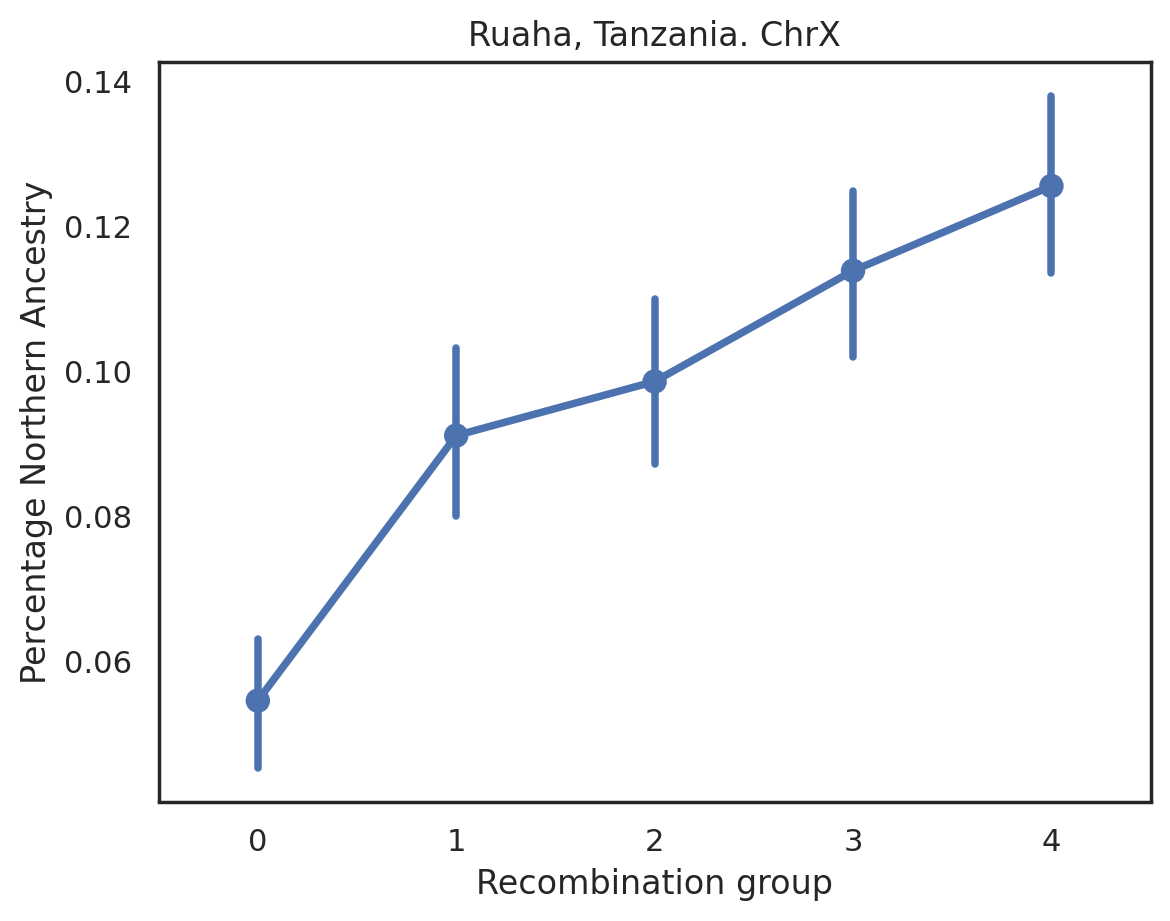

In [41]:
test_pop = meta_data_samples.loc[meta_data_samples.Origin == "Ruaha, Tanzania"].PGDP_ID
df = mean_df.loc[mean_df["individual"].isin(test_pop)]
mean_df_2 = (df.groupby(["start"])[["north"]].mean())
df_2 = df.loc[df.start.isin(mean_df_2.loc[mean_df_2.north < 0.5].index)]
g = sns.pointplot(data=df_2, y="north", x="recomb_group", errorbar=('ci', 95))
g.set(title="Ruaha, Tanzania. ChrX")
g.set(xlabel="Recombination group", ylabel="Percentage Northern Ancestry")

[Text(0.5, 0, 'Recombination group'),
 Text(0, 0.5, 'Percentage Northern Ancestry')]

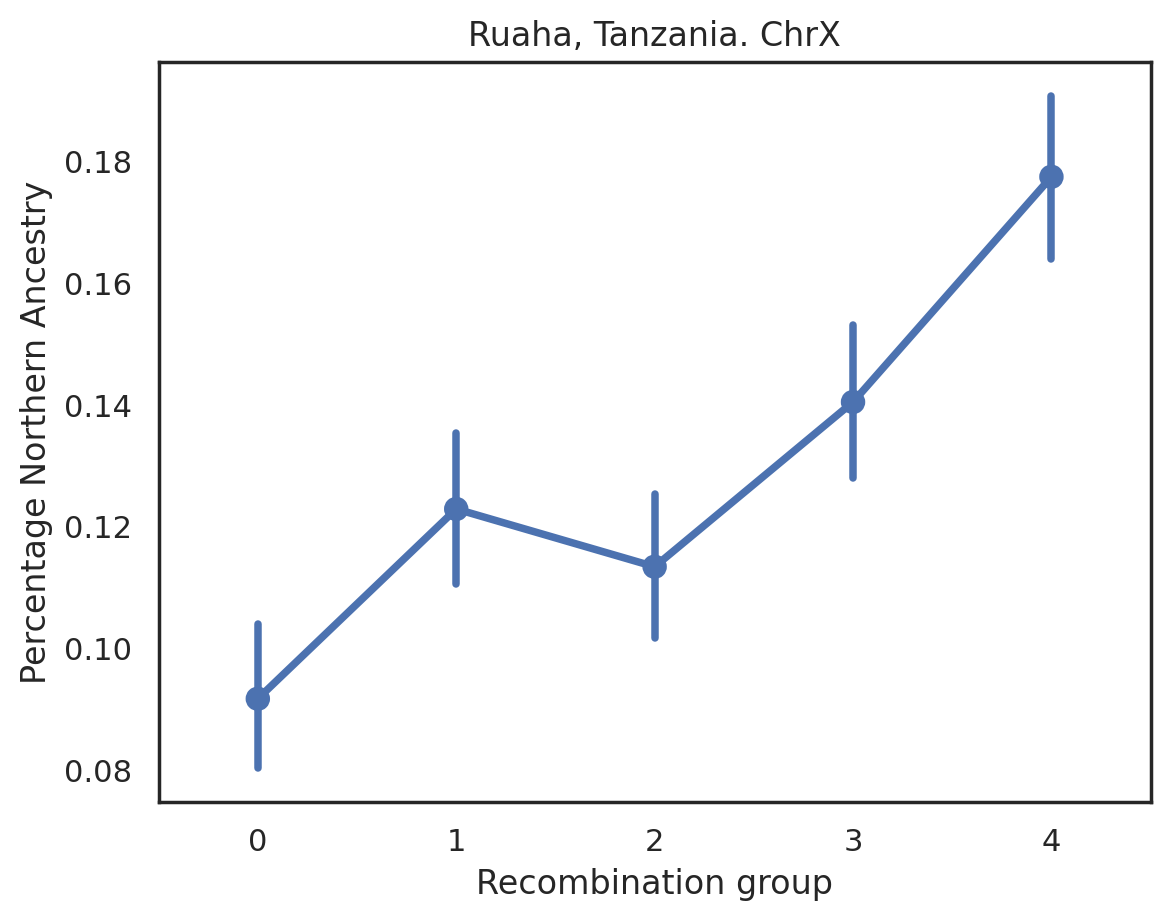

In [86]:
test_pop = meta_data_samples.loc[meta_data_samples.Origin == "Ruaha, Tanzania"].PGDP_ID
df = mean_df.loc[mean_df["individual"].isin(test_pop)]
g = sns.pointplot(data=df, y="north", x="recomb_group", errorbar=('ci', 95))
g.set(title="Ruaha, Tanzania. ChrX")
g.set(xlabel="Recombination group", ylabel="Percentage Northern Ancestry")

In [88]:
mean_df_2 = (df.groupby(["start"])[["north"]].mean())

<Axes: xlabel='genic', ylabel='north'>

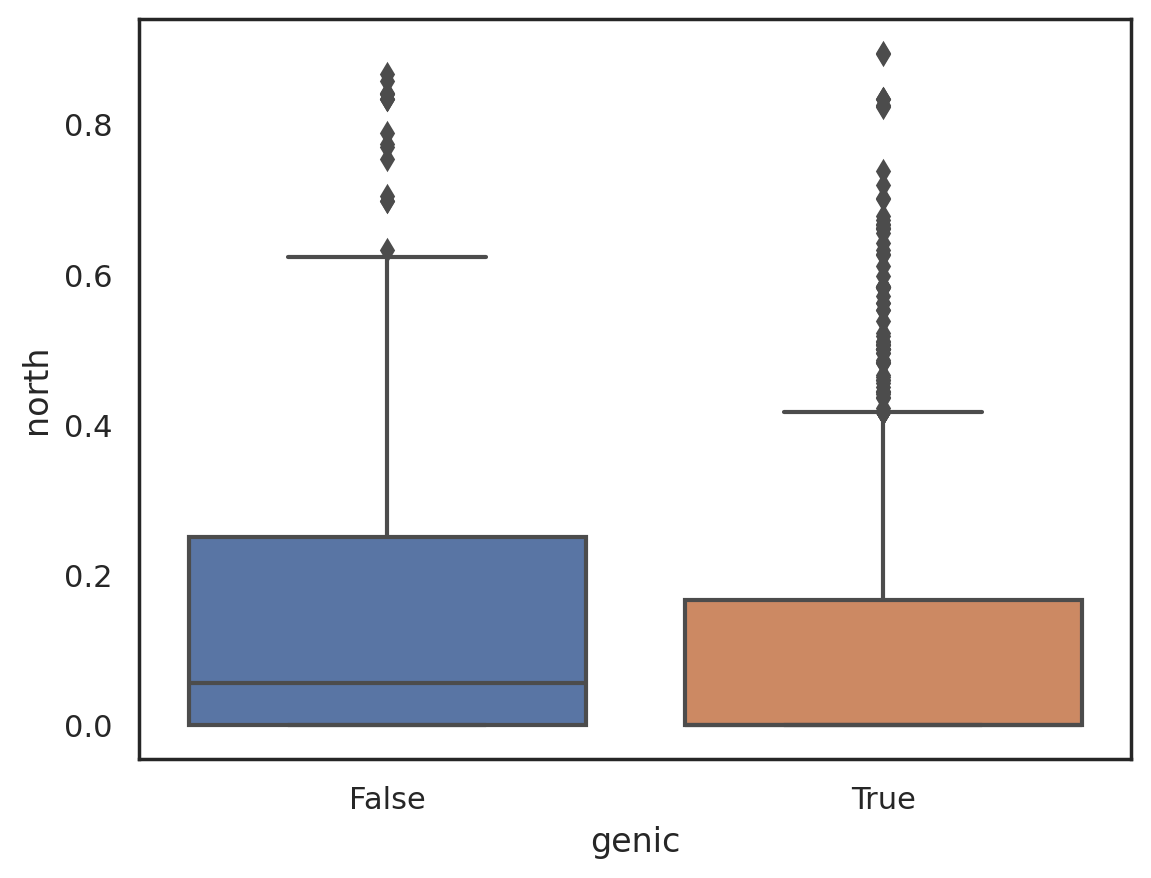

In [89]:
mean_df_2["genes"] = mean_df_2.index.map(gene_pos_mapping)
mean_df_2["genic"] = [True if len(x) > 0 else False for x in mean_df_2.genes]
sns.boxplot(data=mean_df_2, y="north", x="genic")

In [90]:
mean_df_2.loc[mean_df_2.genic == True].north.mean(), mean_df_2.loc[mean_df_2.genic == False].north.mean()

(0.12095311384335156, 0.1434509227330779)

[Text(0.5, 0, 'Recombination group'),
 Text(0, 0.5, 'Percentage Northern Ancestry')]

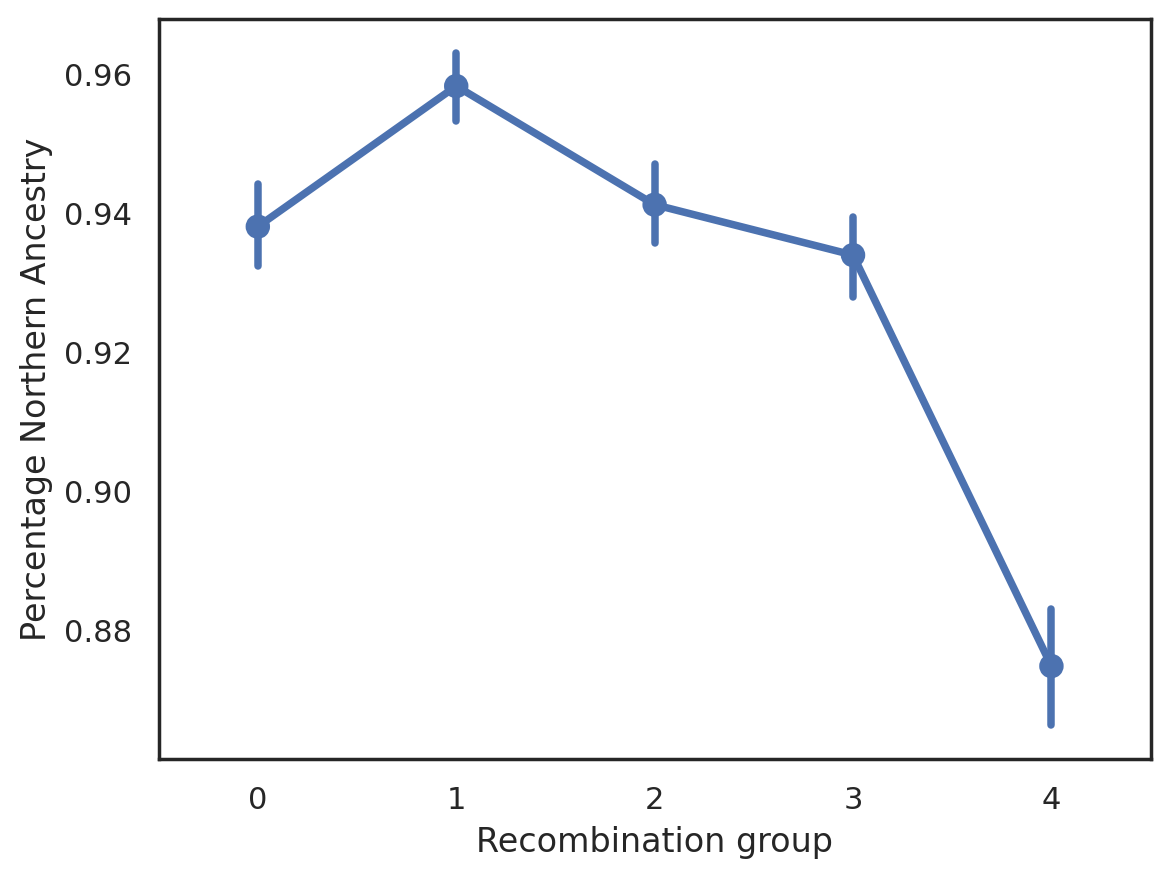

In [91]:
test_pop = meta_data_samples.loc[meta_data_samples.Origin == "Gombe, Tanzania"].PGDP_ID
df = mean_df.loc[mean_df["individual"].isin(test_pop)]
g = sns.pointplot(data=df, y="north", x="recomb_group", errorbar=('ci', 95))
g.set(xlabel="Recombination group", ylabel="Percentage Northern Ancestry")

[Text(0.5, 0, 'Recombination group'),
 Text(0, 0.5, 'Percentage Northern Ancestry')]

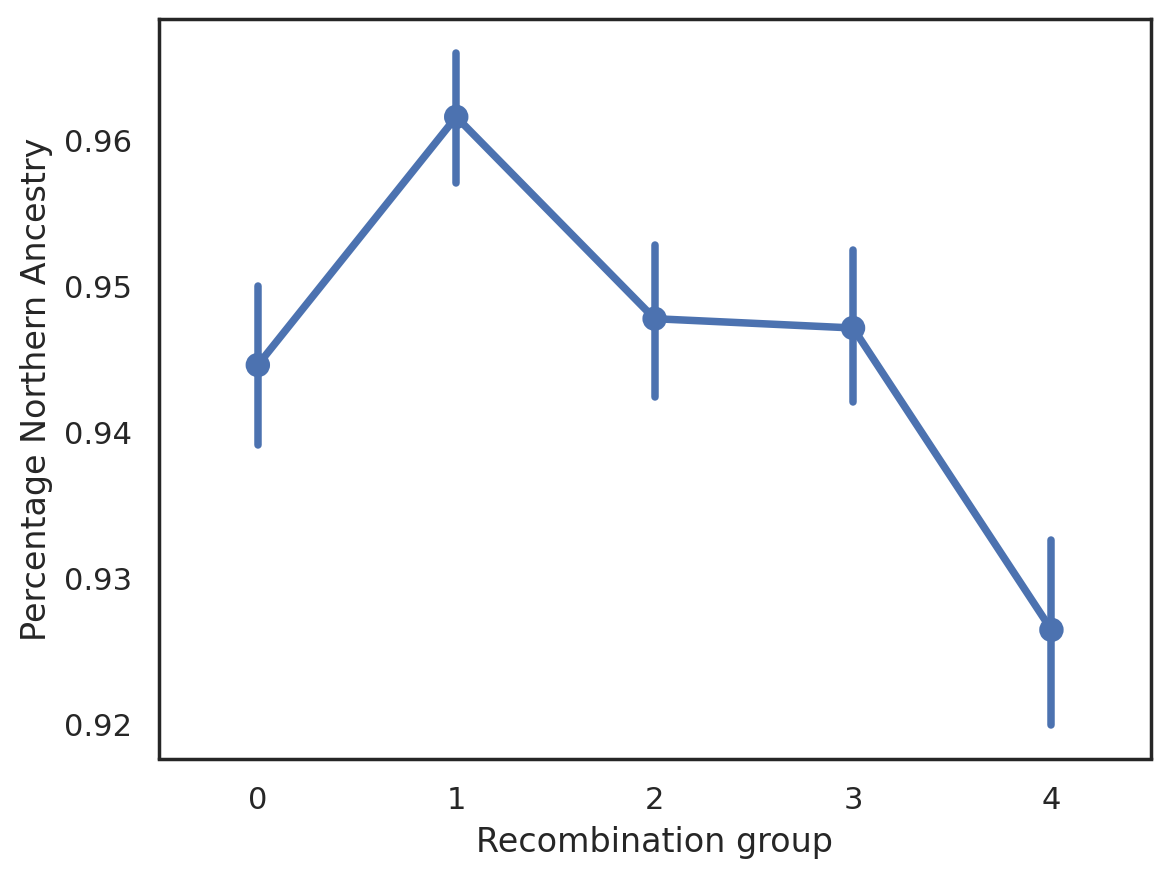

In [92]:
test_pop = meta_data_samples.loc[meta_data_samples.Origin == "Gombe, Tanzania"].PGDP_ID
df = mean_df.loc[mean_df["individual"].isin(test_pop)]
mean_df_2 = (df.groupby(["start"])[["north"]].mean())
df_2 = df.loc[df.start.isin(mean_df_2.loc[mean_df_2.north > 0.1].index)]
g = sns.pointplot(data=df_2, y="north", x="recomb_group", errorbar=('ci', 95))
g.set(xlabel="Recombination group", ylabel="Percentage Northern Ancestry")

In [93]:
df.loc[df.genic == True].north_percentage.mean(), df.loc[df.genic == False].north_percentage.mean()

(0.9302502417229186, 0.927500449628127)

[Text(0.5, 0, 'Recombination group'),
 Text(0, 0.5, 'Percentage Northern Ancestry')]

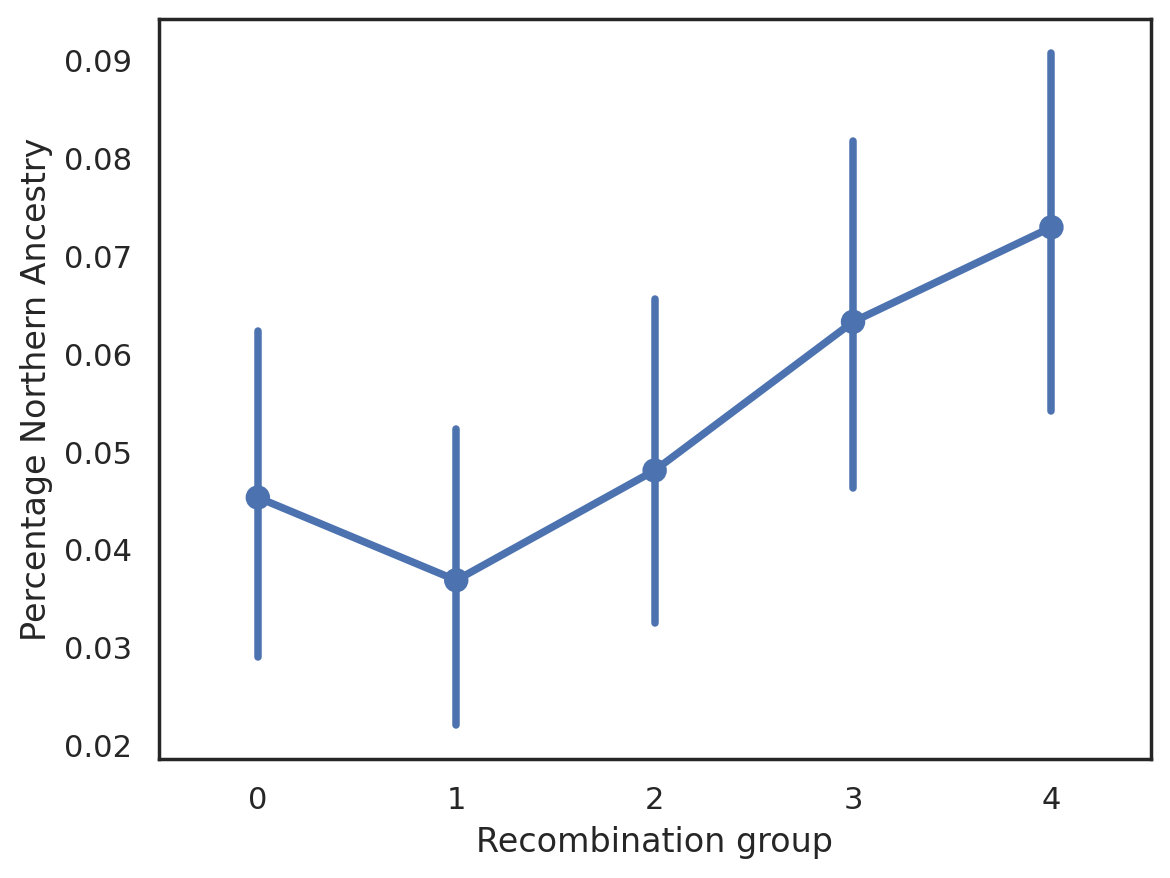

In [94]:
test_pop = meta_data_samples.loc[meta_data_samples.Origin == "Katavi, Tanzania"].PGDP_ID
df = mean_df.loc[mean_df["individual"].isin(test_pop)]
g = sns.pointplot(data=df, y="north", x="recomb_group", errorbar=('ci', 95))
g.set(xlabel="Recombination group", ylabel="Percentage Northern Ancestry")

[Text(0.5, 0, 'Recombination group'),
 Text(0, 0.5, 'Percentage Northern Ancestry')]

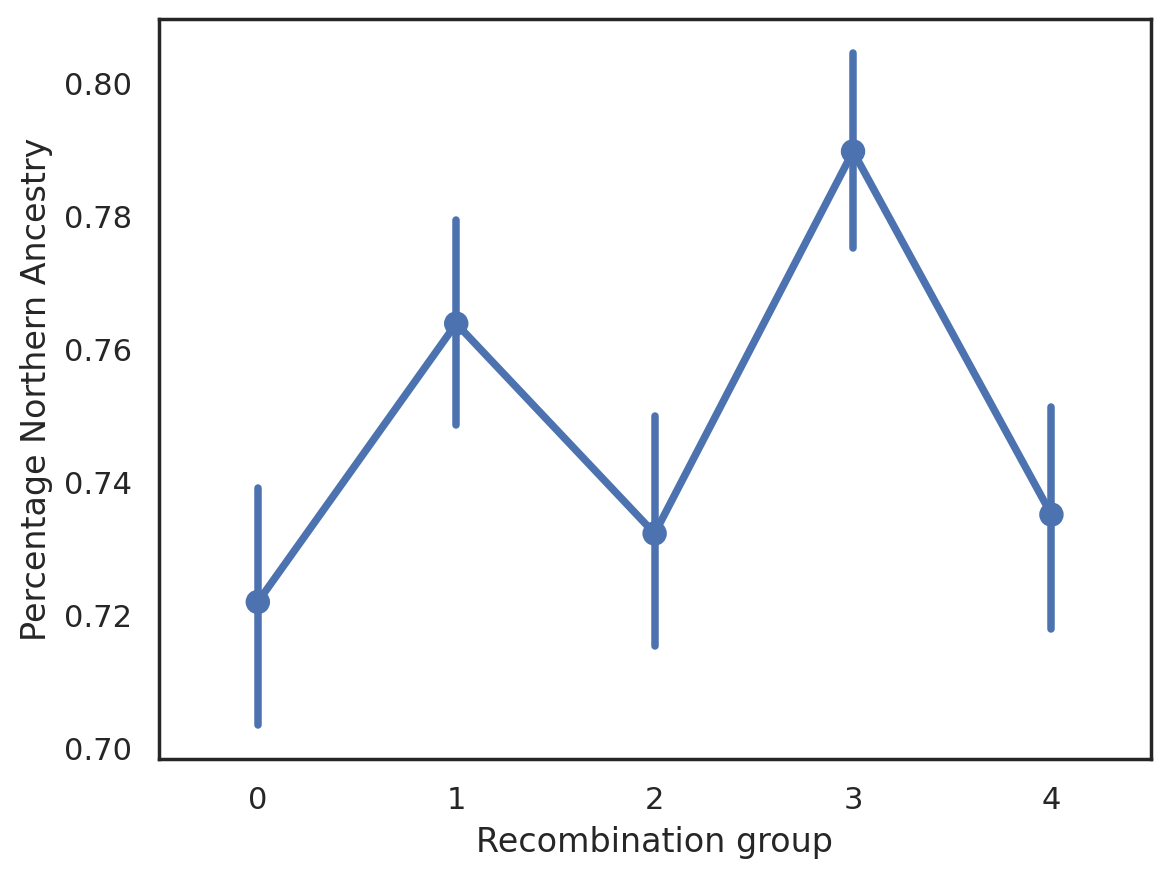

In [95]:
test_pop = meta_data_samples.loc[meta_data_samples.Origin == "Tarangire, Tanzania"].PGDP_ID
df = mean_df.loc[mean_df["individual"].isin(test_pop)]
g = sns.pointplot(data=df, y="north", x="recomb_group", errorbar=('ci', 95))
g.set(xlabel="Recombination group", ylabel="Percentage Northern Ancestry")

[Text(0.5, 0, 'Recombination group'),
 Text(0, 0.5, 'Percentage Northern Ancestry')]

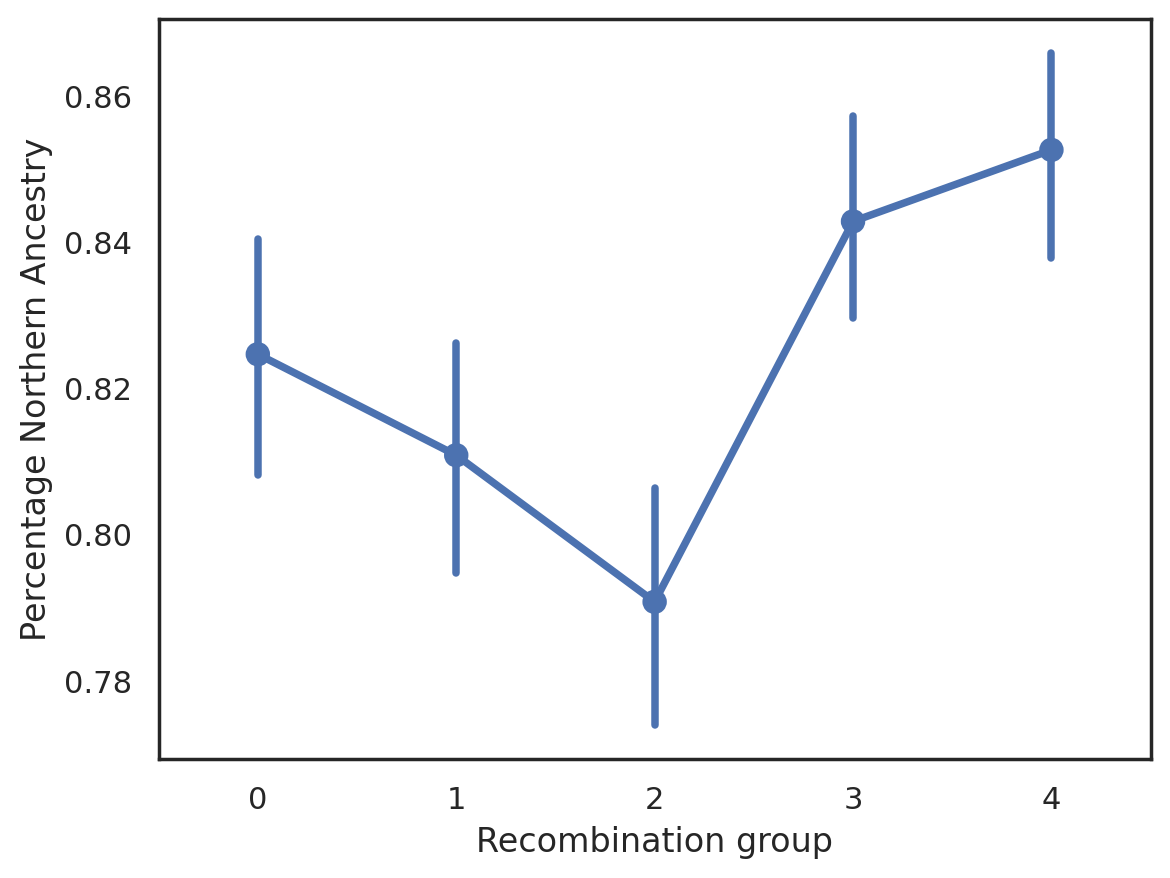

In [96]:
test_pop = meta_data_samples.loc[meta_data_samples.Origin == "Tarangire, Tanzania"].PGDP_ID
df = mean_df.loc[mean_df["individual"].isin(test_pop)]
mean_df_2 = (df.groupby(["start"])[["north"]].mean())
df_2 = df.loc[df.start.isin(mean_df_2.loc[mean_df_2.north > 0.5].index)]
g = sns.pointplot(data=df_2, y="north", x="recomb_group", errorbar=('ci', 95))
g.set(xlabel="Recombination group", ylabel="Percentage Northern Ancestry")

<Axes: xlabel='genic', ylabel='north_percentage'>

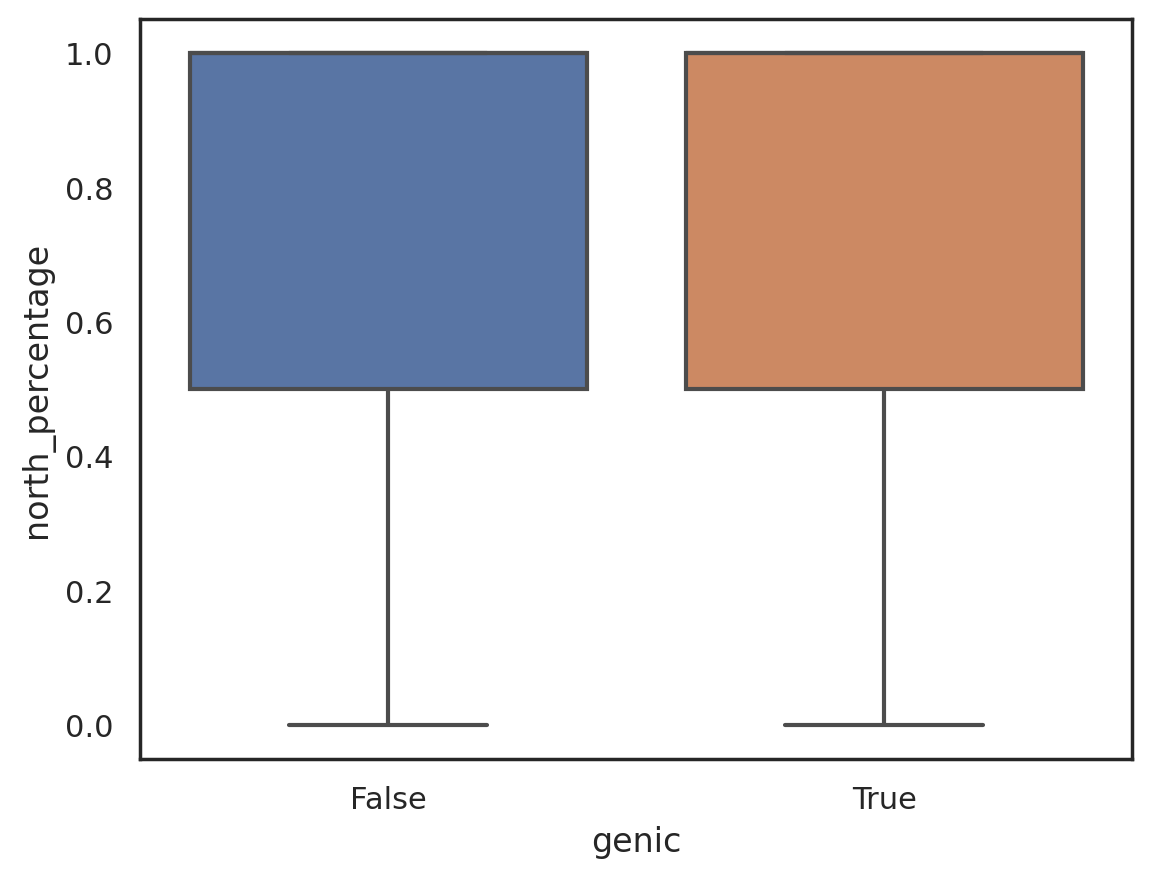

In [97]:
test_pop = meta_data_samples.loc[meta_data_samples.Origin == "Tarangire, Tanzania"].PGDP_ID
df = mean_df.loc[mean_df["individual"].isin(test_pop)]
sns.boxplot(data=df, y="north_percentage", x="genic")

In [98]:
df.loc[df.genic == False].north_percentage.mean(), df.loc[df.genic == True].north_percentage.mean()

(0.7336615722495896, 0.7569610921155348)

[Text(0.5, 0, 'Recombination group'),
 Text(0, 0.5, 'Percentage Northern Ancestry')]

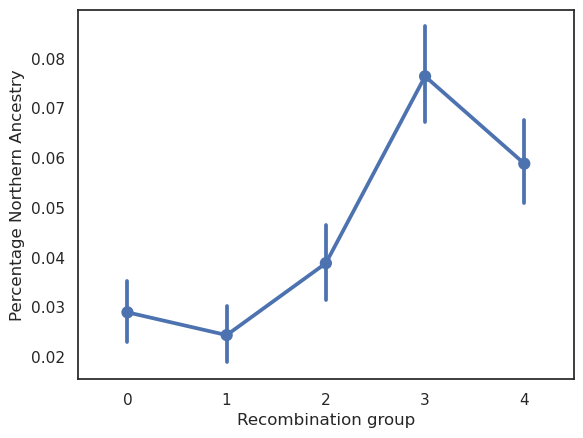

In [15]:
test_pop = meta_data_samples.loc[meta_data_samples.Origin == "Mahale, Tanzania"].PGDP_ID
df = mean_df.loc[mean_df["individual"].isin(test_pop)]
g = sns.pointplot(data=df, y="north", x="recomb_group", errorbar=('ci', 95))
g.set(xlabel="Recombination group", ylabel="Percentage Northern Ancestry")

[Text(0.5, 0, 'Recombination group'),
 Text(0, 0.5, 'Percentage Northern Ancestry')]

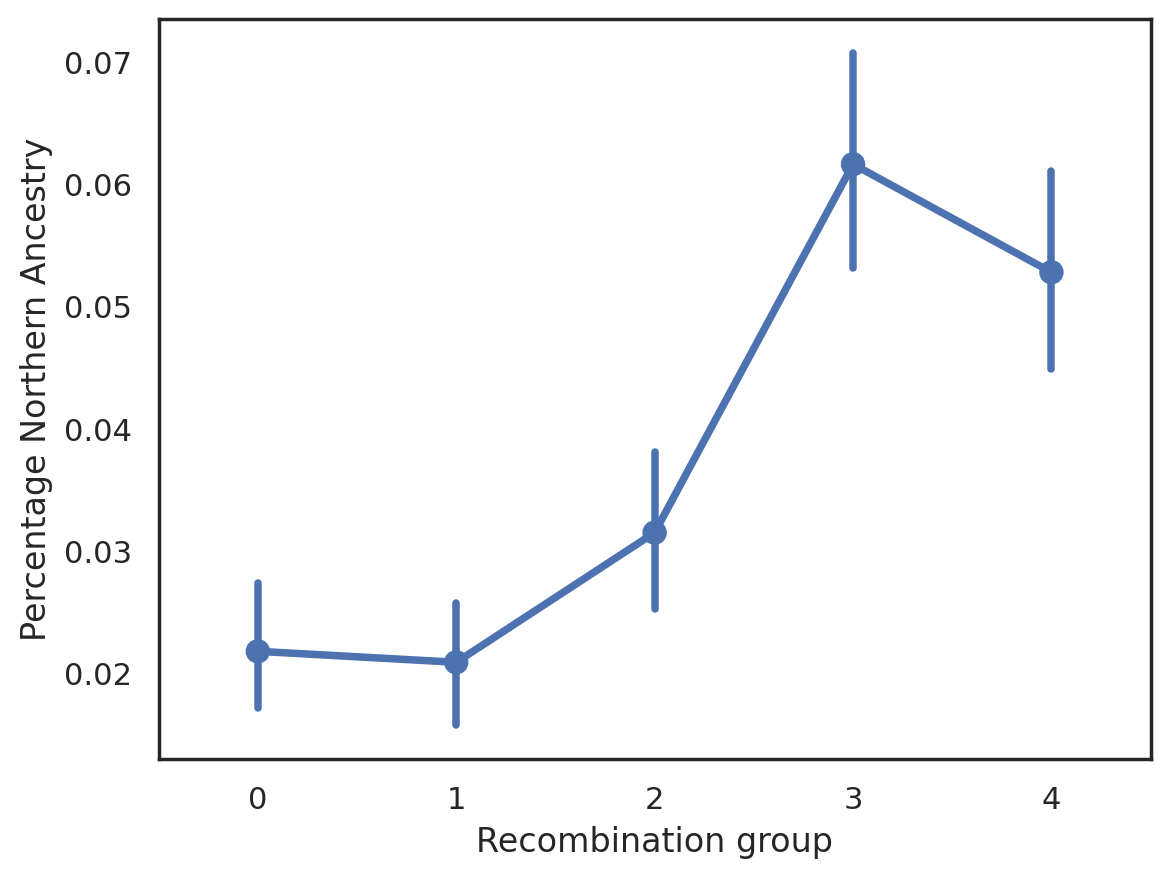

In [160]:
test_pop = meta_data_samples.loc[meta_data_samples.Origin == "Mahale, Tanzania"].PGDP_ID
df = mean_df.loc[mean_df["individual"].isin(test_pop)]
mean_df_2 = (df.groupby(["start"])[["north"]].mean())
df_2 = df.loc[df.start.isin(mean_df_2.loc[mean_df_2.north < 0.5].index)]
g = sns.pointplot(data=df_2, y="north", x="recomb_group", errorbar=('ci', 95))
g.set(xlabel="Recombination group", ylabel="Percentage Northern Ancestry")

In [108]:
serengeti = meta_data_samples.loc[meta_data_samples.Origin == "Serengeti, Tanzania"].PGDP_ID
serengeti_df = chr_df.loc[chr_df["individual"].isin(serengeti)]
serengeti_mean_df = serengeti_df.groupby(by=["chrom", "start"])[["north_percentage"]].mean().reset_index()
non_taran = meta_data_samples.loc[meta_data_samples.Origin.isin(["Serengeti, Tanzania",
                                                                 "Lake Manyara, Tanzania",
                                                                "Arusha, Tanzania",
                                                                "Gombe, Tanzania",
                                                                "Ngorongoro, Tanzania"])].PGDP_ID
non_taran_df = chr_df.loc[chr_df["individual"].isin(non_taran)]
non_taran_mean_df = non_taran_df.groupby(by=["chrom", "start"])[["north_percentage"]].mean().reset_index()
gombe = meta_data_samples.loc[meta_data_samples.Origin == "Gombe, Tanzania"].PGDP_ID
gombe_df = chr_df.loc[chr_df["individual"].isin(gombe)]
gombe_mean_df = gombe_df.groupby(by=["chrom", "start"])[["north_percentage"]].mean().reset_index()
ruaha = meta_data_samples.loc[meta_data_samples.Origin == "Ruaha, Tanzania"].PGDP_ID
ruaha_df = chr_df.loc[chr_df["individual"].isin(ruaha)]
ruaha_mean_df = ruaha_df.groupby(by=["chrom", "start"])[["north_percentage"]].mean().reset_index()


In [112]:
from scipy import stats

stats.spearmanr(non_taran_mean_df["north_percentage"], 1-ruaha_mean_df["north_percentage"])

SignificanceResult(statistic=0.09292462874259078, pvalue=0.00042008227193149003)

[Text(0.5, 0, 'Yellow Major Parent Ancestry'),
 Text(0, 0.5, 'Olive Major Parent Ancestry')]

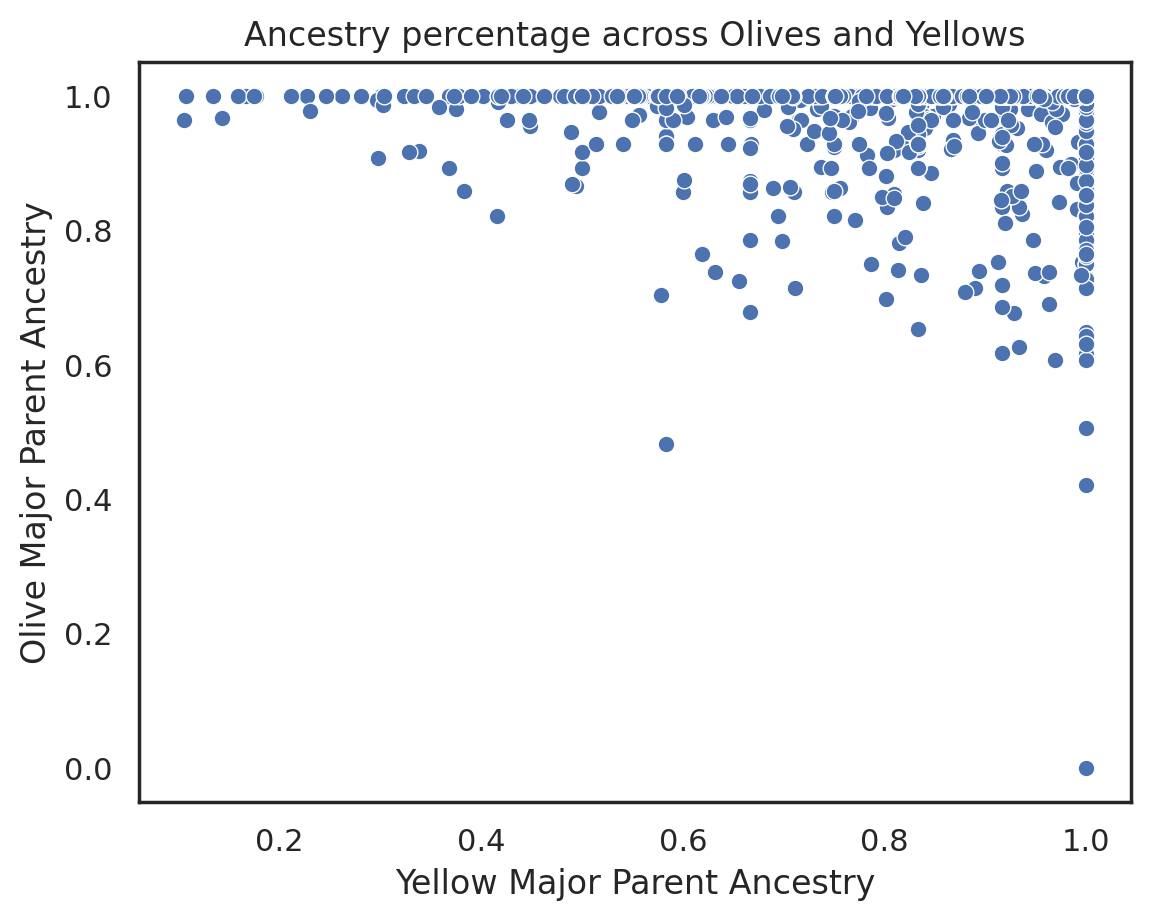

In [113]:
g = sns.scatterplot(y=serengeti_mean_df["north_percentage"], x=1-ruaha_mean_df["north_percentage"])
g.set(title="Ancestry percentage across Olives and Yellows")
g.set(xlabel="Yellow Major Parent Ancestry", ylabel="Olive Major Parent Ancestry")

Autosomal section

In [43]:
pos_mapping = {}
recomb_window_l = []
for c in window_df.chrom.unique():
    print(c)
    chr_df = window_df.loc[(window_df.chrom == c)]
    windows = chr_df.start.unique()
    max_window = windows.max()
    genetic_map = "/home/eriks/baboondiversity/data/PG_panu3_recombination_map/mikumi_pyrho_genetic_map_{}.txt"
    if c not in ["all_chrX", "female_chrX"]:
        chr_recomb = pd.read_csv(genetic_map.format(c), sep=" ")
        chr_genes = gi.get_genes_region(c, 0, max_window, assembly='papAnu4')
    else:
        chr_recomb = pd.read_csv(genetic_map.format("chrX"), sep=" ")
        chr_genes = gi.get_genes_region('chrX', 0, max_window, assembly='papAnu4')
    for s in chr_df.start.unique():
        if s % 25000000 == 0:
            print(s/max_window)
        cM_pos = chr_recomb.loc[chr_recomb.position >= s]["Genetic_Map(cM)"].iloc[0]
        pos_mapping[s] = cM_pos
    chr_df["cM"] = chr_df.start.map(pos_mapping)
    end_cM = pd.concat([chr_df.cM.iloc[1:], pd.Series(chr_recomb["Genetic_Map(cM)"].max())], ignore_index=True)
    chr_df["average_cM_window"] = (end_cM - chr_df.cM) / (chr_df.end - chr_df.start)
    gene_list = []
    gene_pos_mapping = {}
    for g in chr_genes:
        #print(g)
        if g in gene_list: #or g[0][:3] == "LOC":
            pass
        else:
            gene_list.append(g)
    for w in range(0, max_window+100000, 100000):
        gene_pos_mapping[w] = []
    for g in gene_list:
        s, e = (g[1]//100000)*100000, (g[2]//100000)*100000
        for i in range(s, e+100000, 100000):
            gene_pos_mapping[i].append(g[0])
    chr_df["genes"] = chr_df.start.map(gene_pos_mapping)
    chr_df["genic"] = [True if len(x) > 0 else False for x in chr_df.genes]
    recomb_window_l.append(chr_df)

chr1
0.0
0.11499540018399264
0.22999080036798528
0.34498620055197793
0.45998160073597055
0.5749770009199632
0.6899724011039559
0.8049678012879485
0.9199632014719411


/scratch/23698326/ipykernel_3016234/230455139.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["cM"] = chr_df.start.map(pos_mapping)
/scratch/23698326/ipykernel_3016234/230455139.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["average_cM_window"] = (end_cM - chr_df.cM) / (chr_df.end - chr_df.start)
/scratch/23698326/ipykernel_3016234/230455139.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

chr2
0.0
0.13283740701381508
0.26567481402763016
0.3985122210414453
0.5313496280552603
0.6641870350690755
0.7970244420828906
0.9298618490967057


/scratch/23698326/ipykernel_3016234/230455139.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["cM"] = chr_df.start.map(pos_mapping)
/scratch/23698326/ipykernel_3016234/230455139.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["average_cM_window"] = (end_cM - chr_df.cM) / (chr_df.end - chr_df.start)
/scratch/23698326/ipykernel_3016234/230455139.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

chr3
0.0
0.13789299503585217
0.27578599007170435
0.4136789851075565
0.5515719801434087
0.6894649751792609
0.827357970215113
0.9652509652509652


/scratch/23698326/ipykernel_3016234/230455139.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["cM"] = chr_df.start.map(pos_mapping)
/scratch/23698326/ipykernel_3016234/230455139.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["average_cM_window"] = (end_cM - chr_df.cM) / (chr_df.end - chr_df.start)
/scratch/23698326/ipykernel_3016234/230455139.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

chr4
0.0
0.15060240963855423
0.30120481927710846
0.45180722891566266
0.6024096385542169
0.7530120481927711
0.9036144578313253


/scratch/23698326/ipykernel_3016234/230455139.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["cM"] = chr_df.start.map(pos_mapping)
/scratch/23698326/ipykernel_3016234/230455139.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["average_cM_window"] = (end_cM - chr_df.cM) / (chr_df.end - chr_df.start)
/scratch/23698326/ipykernel_3016234/230455139.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

chr5
0.0
0.1360914534567229
0.2721829069134458
0.40827436037016873
0.5443658138268916
0.6804572672836146
0.8165487207403375
0.9526401741970604


/scratch/23698326/ipykernel_3016234/230455139.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["cM"] = chr_df.start.map(pos_mapping)
/scratch/23698326/ipykernel_3016234/230455139.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["average_cM_window"] = (end_cM - chr_df.cM) / (chr_df.end - chr_df.start)
/scratch/23698326/ipykernel_3016234/230455139.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

chr6
0.0
0.1426126640045636
0.2852253280091272
0.4278379920136908
0.5704506560182544
0.713063320022818
0.8556759840273817
0.9982886480319453


/scratch/23698326/ipykernel_3016234/230455139.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["cM"] = chr_df.start.map(pos_mapping)
/scratch/23698326/ipykernel_3016234/230455139.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["average_cM_window"] = (end_cM - chr_df.cM) / (chr_df.end - chr_df.start)
/scratch/23698326/ipykernel_3016234/230455139.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

chr7
0.0
0.15356265356265356
0.3071253071253071
0.4606879606879607
0.6142506142506142
0.7678132678132679
0.9213759213759214


/scratch/23698326/ipykernel_3016234/230455139.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["cM"] = chr_df.start.map(pos_mapping)
/scratch/23698326/ipykernel_3016234/230455139.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["average_cM_window"] = (end_cM - chr_df.cM) / (chr_df.end - chr_df.start)
/scratch/23698326/ipykernel_3016234/230455139.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

chr8
0.0
0.1781895937277263
0.3563791874554526
0.5345687811831789
0.7127583749109052
0.8909479686386315


/scratch/23698326/ipykernel_3016234/230455139.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["cM"] = chr_df.start.map(pos_mapping)
/scratch/23698326/ipykernel_3016234/230455139.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["average_cM_window"] = (end_cM - chr_df.cM) / (chr_df.end - chr_df.start)
/scratch/23698326/ipykernel_3016234/230455139.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

chr9
0.0
0.19888623707239458
0.39777247414478917
0.5966587112171837
0.7955449482895783
0.994431185361973


/scratch/23698326/ipykernel_3016234/230455139.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["cM"] = chr_df.start.map(pos_mapping)
/scratch/23698326/ipykernel_3016234/230455139.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["average_cM_window"] = (end_cM - chr_df.cM) / (chr_df.end - chr_df.start)
/scratch/23698326/ipykernel_3016234/230455139.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

chr10
0.0
0.2738225629791895
0.547645125958379
0.8214676889375685


/scratch/23698326/ipykernel_3016234/230455139.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["cM"] = chr_df.start.map(pos_mapping)
/scratch/23698326/ipykernel_3016234/230455139.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["average_cM_window"] = (end_cM - chr_df.cM) / (chr_df.end - chr_df.start)
/scratch/23698326/ipykernel_3016234/230455139.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

chr11
0.0
0.18811136192626035
0.3762227238525207
0.5643340857787811
0.7524454477050414
0.9405568096313017


/scratch/23698326/ipykernel_3016234/230455139.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["cM"] = chr_df.start.map(pos_mapping)
/scratch/23698326/ipykernel_3016234/230455139.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["average_cM_window"] = (end_cM - chr_df.cM) / (chr_df.end - chr_df.start)
/scratch/23698326/ipykernel_3016234/230455139.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

chr12
0.0
0.19500780031201248
0.39001560062402496
0.5850234009360374
0.7800312012480499
0.9750390015600624


/scratch/23698326/ipykernel_3016234/230455139.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["cM"] = chr_df.start.map(pos_mapping)
/scratch/23698326/ipykernel_3016234/230455139.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["average_cM_window"] = (end_cM - chr_df.cM) / (chr_df.end - chr_df.start)
/scratch/23698326/ipykernel_3016234/230455139.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

chr13
0.0
0.23832221163012393
0.47664442326024786
0.7149666348903718
0.9532888465204957


/scratch/23698326/ipykernel_3016234/230455139.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["cM"] = chr_df.start.map(pos_mapping)
/scratch/23698326/ipykernel_3016234/230455139.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["average_cM_window"] = (end_cM - chr_df.cM) / (chr_df.end - chr_df.start)
/scratch/23698326/ipykernel_3016234/230455139.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

chr14
0.0
0.20080321285140562
0.40160642570281124
0.6024096385542169
0.8032128514056225


/scratch/23698326/ipykernel_3016234/230455139.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["cM"] = chr_df.start.map(pos_mapping)
/scratch/23698326/ipykernel_3016234/230455139.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["average_cM_window"] = (end_cM - chr_df.cM) / (chr_df.end - chr_df.start)
/scratch/23698326/ipykernel_3016234/230455139.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

chr15
0.0
0.23148148148148148
0.46296296296296297
0.6944444444444444
0.9259259259259259


/scratch/23698326/ipykernel_3016234/230455139.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["cM"] = chr_df.start.map(pos_mapping)
/scratch/23698326/ipykernel_3016234/230455139.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["average_cM_window"] = (end_cM - chr_df.cM) / (chr_df.end - chr_df.start)
/scratch/23698326/ipykernel_3016234/230455139.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

chr16
0.0
0.33377837116154874
0.6675567423230975


/scratch/23698326/ipykernel_3016234/230455139.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["cM"] = chr_df.start.map(pos_mapping)
/scratch/23698326/ipykernel_3016234/230455139.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["average_cM_window"] = (end_cM - chr_df.cM) / (chr_df.end - chr_df.start)
/scratch/23698326/ipykernel_3016234/230455139.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

chr17
0.0
0.2738225629791895
0.547645125958379
0.8214676889375685


/scratch/23698326/ipykernel_3016234/230455139.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["cM"] = chr_df.start.map(pos_mapping)
/scratch/23698326/ipykernel_3016234/230455139.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["average_cM_window"] = (end_cM - chr_df.cM) / (chr_df.end - chr_df.start)
/scratch/23698326/ipykernel_3016234/230455139.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

chr18
0.0
0.3448275862068966
0.6896551724137931


/scratch/23698326/ipykernel_3016234/230455139.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["cM"] = chr_df.start.map(pos_mapping)
/scratch/23698326/ipykernel_3016234/230455139.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["average_cM_window"] = (end_cM - chr_df.cM) / (chr_df.end - chr_df.start)
/scratch/23698326/ipykernel_3016234/230455139.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

chr19
0.0
0.4873294346978557
0.9746588693957114


/scratch/23698326/ipykernel_3016234/230455139.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["cM"] = chr_df.start.map(pos_mapping)
/scratch/23698326/ipykernel_3016234/230455139.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["average_cM_window"] = (end_cM - chr_df.cM) / (chr_df.end - chr_df.start)
/scratch/23698326/ipykernel_3016234/230455139.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

chr20
0.0
0.3472222222222222
0.6944444444444444


/scratch/23698326/ipykernel_3016234/230455139.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["cM"] = chr_df.start.map(pos_mapping)
/scratch/23698326/ipykernel_3016234/230455139.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["average_cM_window"] = (end_cM - chr_df.cM) / (chr_df.end - chr_df.start)
/scratch/23698326/ipykernel_3016234/230455139.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

all_chrX
0.0
0.17409470752089137
0.34818941504178275
0.5222841225626741
0.6963788300835655
0.8704735376044568


/scratch/23698326/ipykernel_3016234/230455139.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["cM"] = chr_df.start.map(pos_mapping)
/scratch/23698326/ipykernel_3016234/230455139.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["average_cM_window"] = (end_cM - chr_df.cM) / (chr_df.end - chr_df.start)
/scratch/23698326/ipykernel_3016234/230455139.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

female_chrX
0.0
0.17409470752089137
0.34818941504178275
0.5222841225626741
0.6963788300835655
0.8704735376044568


/scratch/23698326/ipykernel_3016234/230455139.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["cM"] = chr_df.start.map(pos_mapping)
/scratch/23698326/ipykernel_3016234/230455139.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_df["average_cM_window"] = (end_cM - chr_df.cM) / (chr_df.end - chr_df.start)
/scratch/23698326/ipykernel_3016234/230455139.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

In [44]:
all_chr_recomb = pd.concat(recomb_window_l)
all_chr_recomb["north_percentage"] = (all_chr_recomb.north_sum) / (all_chr_recomb.end - all_chr_recomb.start)

In [57]:
def selection_trim_above(filt_df, threshold):
    df_l = []
    for c in filt_df.chrom.unique():
        df = filt_df.loc[filt_df.chrom == c]
        mean_df_2 = (df.groupby(["start"])[["north"]].mean())
        df_2 = df.loc[df.start.isin(mean_df_2.loc[mean_df_2.north >= threshold].index)]
        df_l.append(df_2)
    return pd.concat(df_l)

def selection_trim_below(filt_df, threshold):
    df_l = []
    for c in filt_df.chrom.unique():
        df = filt_df.loc[filt_df.chrom == c]
        mean_df_2 = (df.groupby(["start"])[["north"]].mean())
        df_2 = df.loc[df.start.isin(mean_df_2.loc[mean_df_2.north <= threshold].index)]
        df_l.append(df_2)
    return pd.concat(df_l)

In [75]:
auto_df = all_chr_recomb.loc[~all_chr_recomb.chrom.isin(["all_chrX", "female_chrX"])]
mean_df = all_chr_recomb.groupby(by=["individual", "chrom", "start"])[["north_percentage", "average_cM_window"]].mean().reset_index()
mean_df["north"] = (mean_df.north_percentage)

In [76]:
bins = 5
mean_df["recomb_group"] = pd.qcut(mean_df["average_cM_window"], bins, labels=False)

[Text(0.5, 1.0, 'Non-Tarangire, Tanzania. Autosomes')]

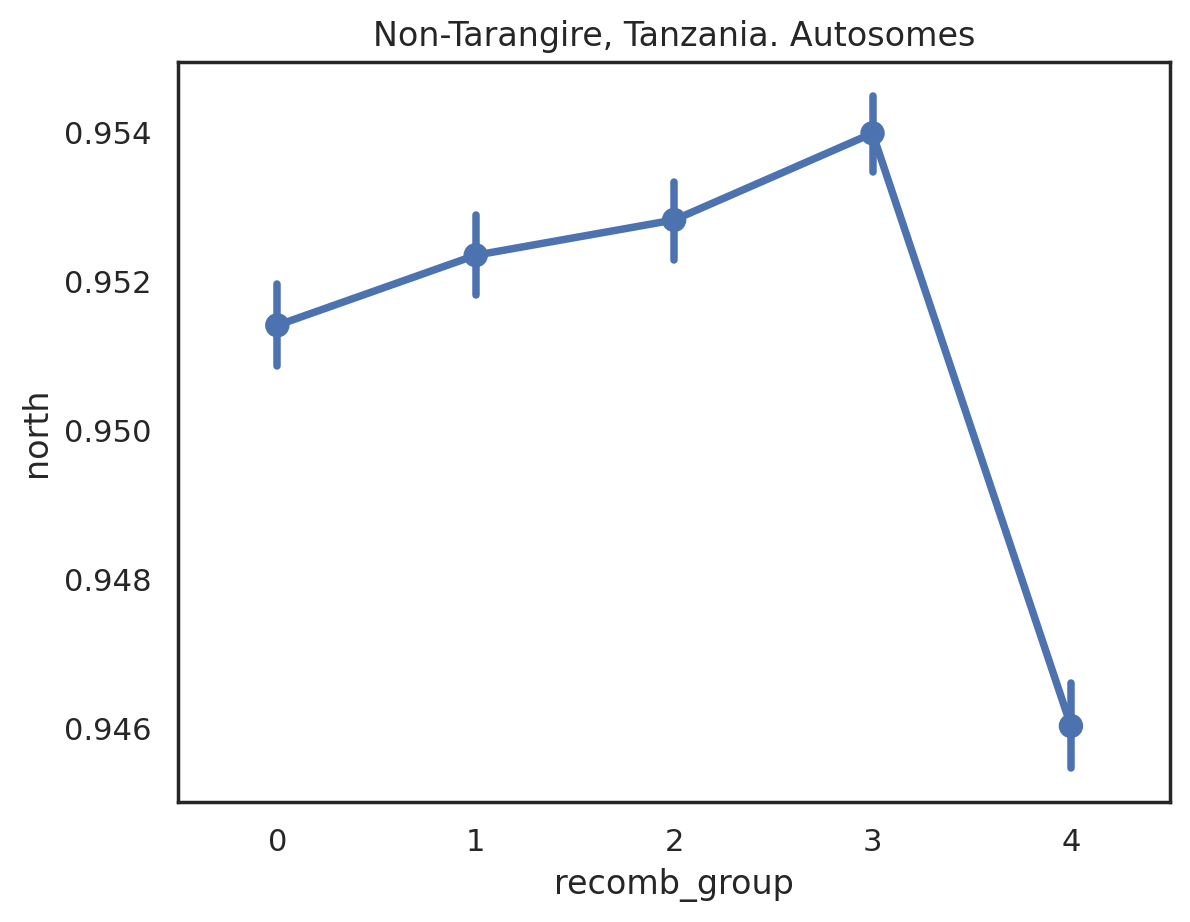

In [77]:
non_taran = meta_data_samples.loc[meta_data_samples.Origin.isin(["Serengeti, Tanzania",
                                                                 "Lake Manyara, Tanzania",
                                                                "Arusha, Tanzania",
                                                                "Gombe, Tanzania",
                                                                "Ngorongoro, Tanzania"])].PGDP_ID
df = mean_df.loc[mean_df["individual"].isin(non_taran)]
g = sns.pointplot(data=df, y="north", x="recomb_group", errorbar=('ci', 95))
g.set(title="Non-Tarangire, Tanzania. Autosomes")

[Text(0.5, 1.0, 'Non-Tarangire, Tanzania. Autosomes')]

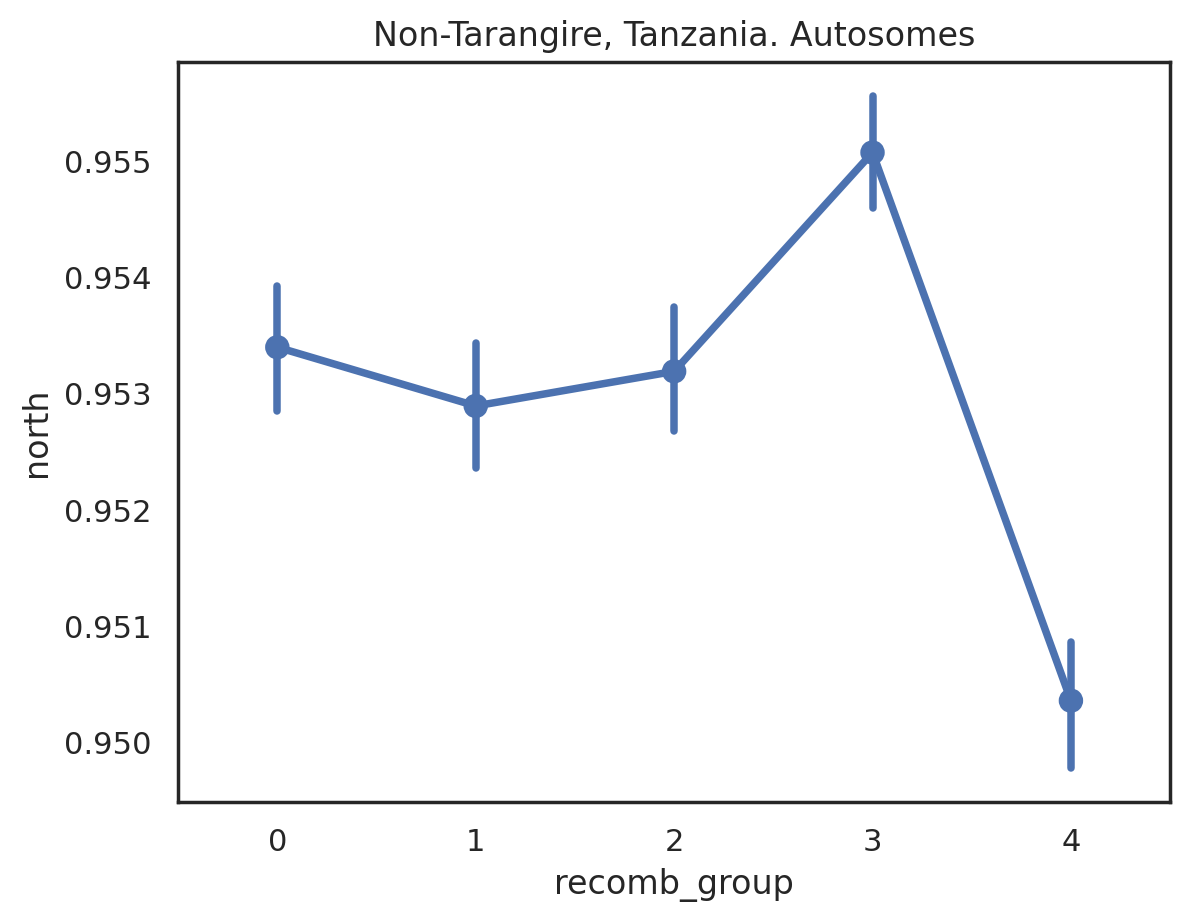

In [78]:
non_taran = meta_data_samples.loc[meta_data_samples.Origin.isin(["Serengeti, Tanzania",
                                                                 "Lake Manyara, Tanzania",
                                                                "Arusha, Tanzania",
                                                                "Gombe, Tanzania",
                                                                "Ngorongoro, Tanzania"])].PGDP_ID
df = mean_df.loc[mean_df["individual"].isin(non_taran)]
df_2 = selection_trim_above(df, 0.5)
g = sns.pointplot(data=df_2, y="north", x="recomb_group", errorbar=('ci', 95))
g.set(title="Non-Tarangire, Tanzania. Autosomes")

[Text(0.5, 1.0, 'Ruaha, Tanzania. Autosomes')]

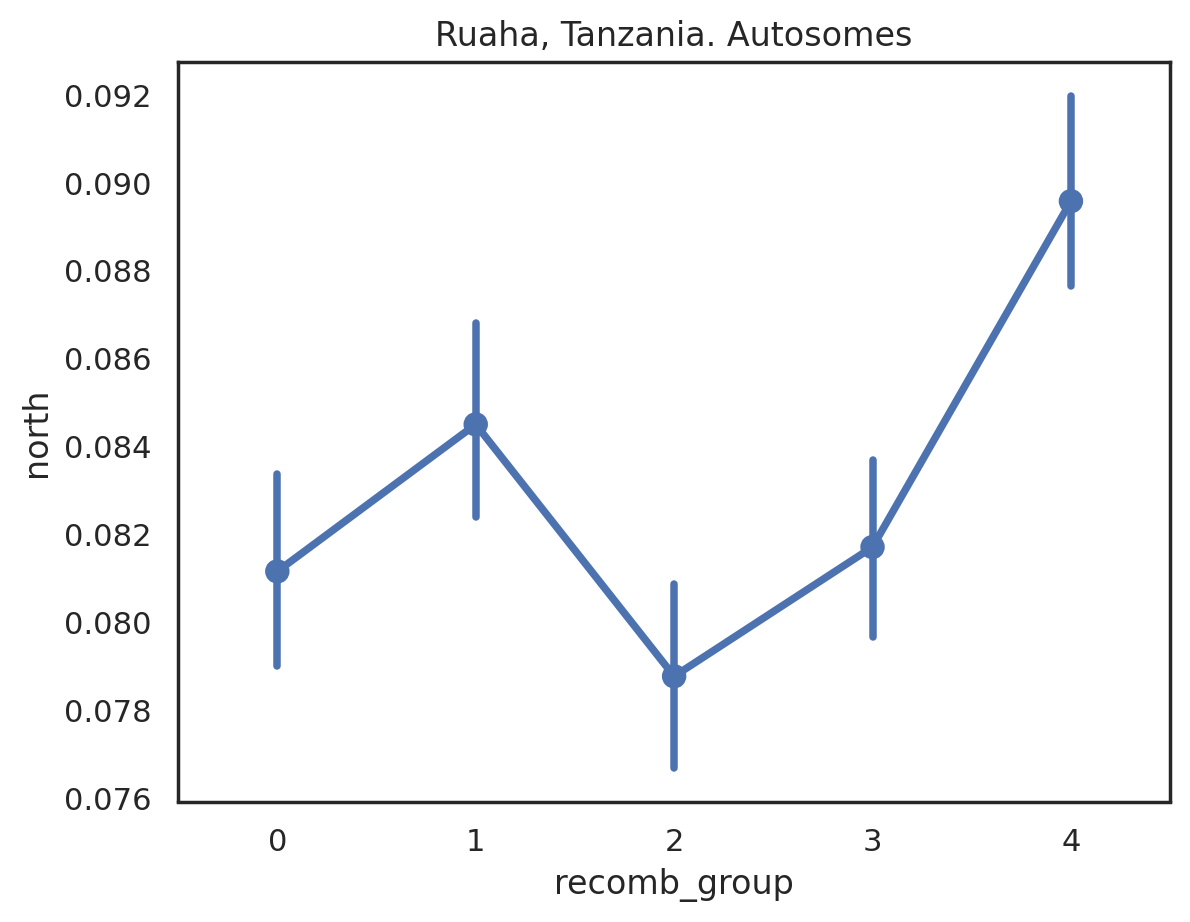

In [79]:
ruaha = meta_data_samples.loc[meta_data_samples.Origin == "Ruaha, Tanzania"].PGDP_ID
df = mean_df.loc[mean_df["individual"].isin(ruaha)]
g = sns.pointplot(data=df, y="north", x="recomb_group", errorbar=('ci', 95))
g.set(title="Ruaha, Tanzania. Autosomes")

[Text(0.5, 1.0, 'Ruaha, Tanzania. Autosomes')]

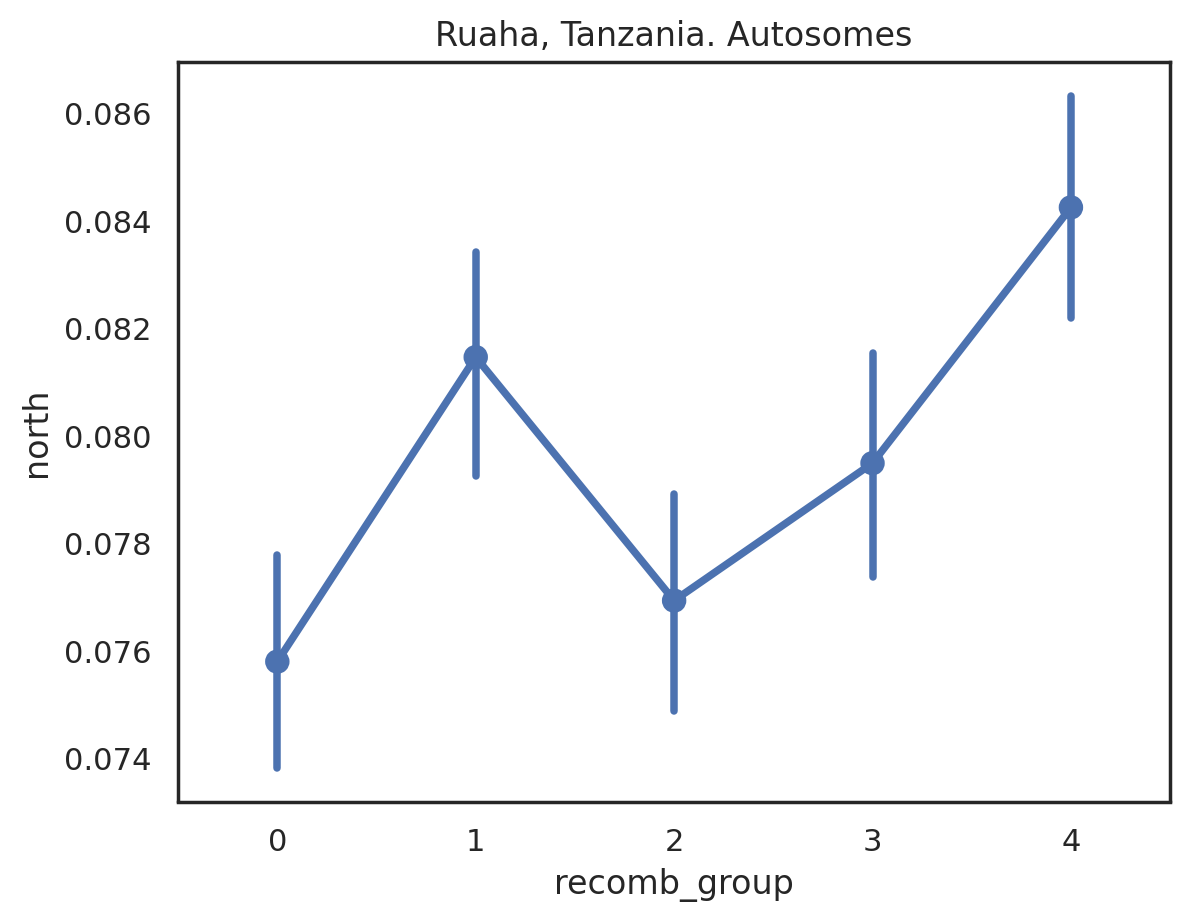

In [80]:
ruaha = meta_data_samples.loc[meta_data_samples.Origin == "Ruaha, Tanzania"].PGDP_ID
df = mean_df.loc[mean_df["individual"].isin(ruaha)]
df_2 = selection_trim_below(df, 0.5)
g = sns.pointplot(data=df_2, y="north", x="recomb_group", errorbar=('ci', 95))
g.set(title="Ruaha, Tanzania. Autosomes")

[Text(0.5, 1.0, 'Issa Valley, Tanzania. Autosomes')]

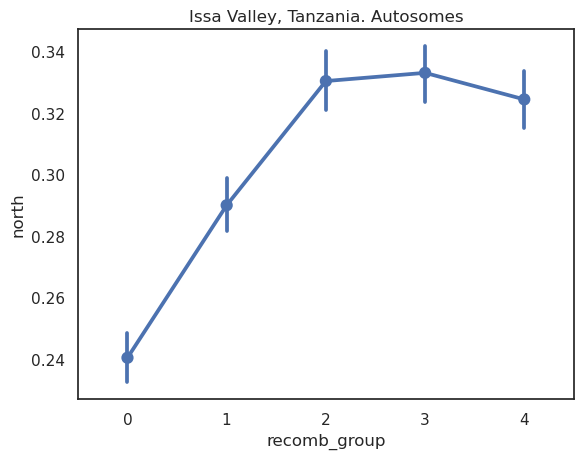

In [129]:
serengeti = meta_data_samples.loc[meta_data_samples.Origin == "Issa Valley, Tanzania"].PGDP_ID
df = mean_df.loc[mean_df["individual"].isin(serengeti)]
g = sns.pointplot(data=df, y="north", x="recomb_group", errorbar=('ci', 95))
g.set(title="Issa Valley, Tanzania. Autosomes")

[Text(0.5, 1.0, 'Mikumi, Tanzania. Autosomes')]

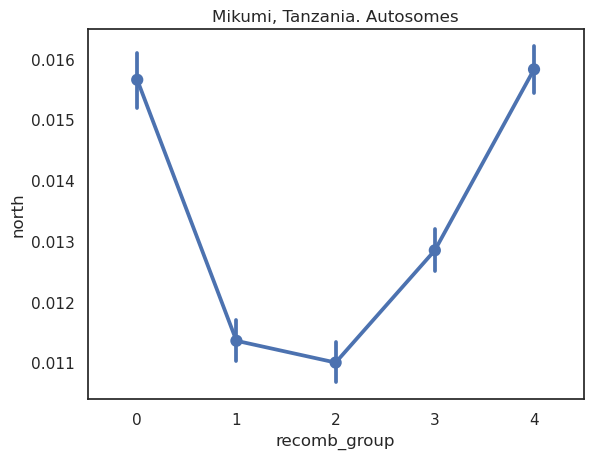

In [145]:
serengeti = meta_data_samples.loc[meta_data_samples.Origin == "Mikumi, Tanzania"].PGDP_ID
df = mean_df.loc[mean_df["individual"].isin(serengeti)]
g = sns.pointplot(data=df, y="north", x="recomb_group", errorbar=('ci', 95))
g.set(title="Mikumi, Tanzania. Autosomes")

In [71]:
autosome_recomb = all_chr_recomb.loc[~all_chr_recomb.chrom.isin(["all_chrX", "female_chrX"])]
serengeti = meta_data_samples.loc[meta_data_samples.Origin == "Serengeti, Tanzania"].PGDP_ID
serengeti_df = autosome_recomb.loc[autosome_recomb["individual"].isin(serengeti)]
serengeti_mean_df = serengeti_df.groupby(by=["chrom", "start"])[["north_percentage"]].mean().reset_index()
gombe = meta_data_samples.loc[meta_data_samples.Origin == "Gombe, Tanzania"].PGDP_ID
gombe_df = autosome_recomb.loc[autosome_recomb["individual"].isin(gombe)]
gombe_mean_df = gombe_df.groupby(by=["chrom", "start"])[["north_percentage"]].mean().reset_index()
ruaha = meta_data_samples.loc[meta_data_samples.Origin == "Ruaha, Tanzania"].PGDP_ID
ruaha_df = autosome_recomb.loc[autosome_recomb["individual"].isin(ruaha)]
ruaha_mean_df = ruaha_df.groupby(by=["chrom", "start"])[["north_percentage"]].mean().reset_index()


[Text(0.5, 0, 'Yellow Major Parent Ancestry'),
 Text(0, 0.5, 'Olive Major Parent Ancestry')]

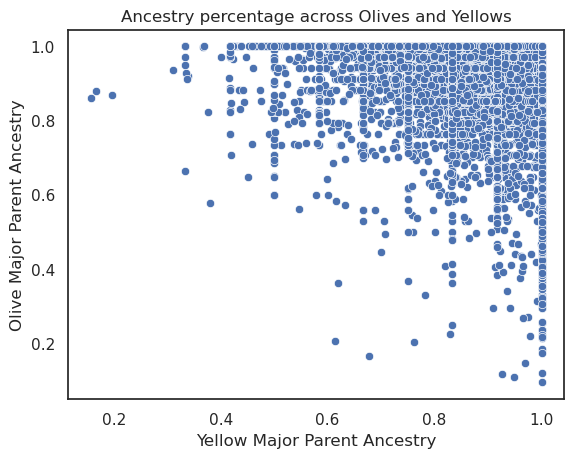

In [73]:
g = sns.scatterplot(y=gombe_mean_df["north_percentage"], x=1-ruaha_mean_df["north_percentage"])
g.set(title="Ancestry percentage across Olives and Yellows")
g.set(xlabel="Yellow Major Parent Ancestry", ylabel="Olive Major Parent Ancestry")

<Axes: xlabel='north_percentage', ylabel='Count'>

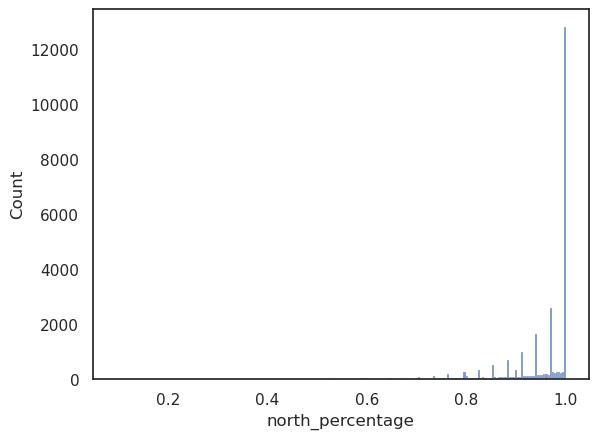

In [123]:
sns.histplot(x=gombe_mean_df["north_percentage"])
#sns.histplot(x=serengeti_mean_df["north_percentage"])


In [94]:
merged_df = serengeti_mean_df.merge(right=ruaha_mean_df, on=["chrom", "start"])

In [132]:
((merged_df.north_percentage_x > 0.9) & (merged_df.north_percentage_y < 0.20)).sum()

20195

In [133]:
((merged_df.north_percentage_x < 0.9) & (merged_df.north_percentage_y < 0.20)).sum()

2698

In [134]:
((merged_df.north_percentage_x > 0.9) & (merged_df.north_percentage_y > 0.20)).sum()

2507

In [135]:
((merged_df.north_percentage_x < 0.9) & (merged_df.north_percentage_y > 0.20)).sum()

315

In [113]:
sum([14174, 4211, 5543, 1555])

25483

In [141]:
(merged_df.north_percentage_x < 0.9).sum()*(merged_df.north_percentage_y > 0.20).sum()/25483

335.2583290821332

In [136]:
from scipy.stats import chisquare

chisquare(f_obs=[20195, 2698, 2507, 315])

Power_divergenceResult(statistic=39850.07921446626, pvalue=0.0)